In [29]:
import math
import compyute as cp

cp.random.set_seed(0)

# Transformer Architecture

D. Kofler, Project II: Concept Study, AppDS, SS2024

Based on the paper by Vaswani et. al (https://arxiv.org/pdf/1706.03762).

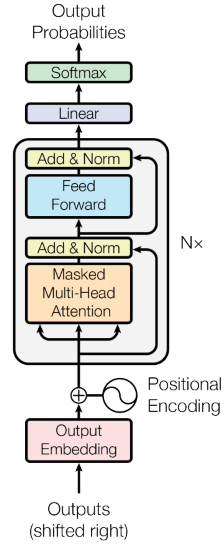

### Input

The Input to a transformer that uses language needs to be numerical. For this, a vocabulary is needed that maps from numerical ids to tokens (e.g. a character, word or part of a word). In this example, just lower case letters are used. Each letter is assigned an id.

In practice, tokenizers that use specific algorithms (such as byte-pair-encoding) are used to create a vocabulary of tokens, by learning from text-data.

- Vocabulary Size $ V $: number of possible tokens

In [30]:
from string import ascii_lowercase

vocabulary = {i:s for i, s in enumerate(ascii_lowercase + " ")}  # maps id to token
inverse_vocabulary = {s:i for i, s in vocabulary.items()}  # maps token to id
vocab_size = len(vocabulary)

vocabulary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: ' '}

The vocabulary can be used to encode text.

In [31]:
text_input = "hello world"
token_ids = cp.tensor([[inverse_vocabulary[s] for s in text_input]])

print(f"\"{text_input}\" is mapped to {token_ids}")

"hello world" is mapped to Tensor([[ 7,  4, 11, 11, 14, 26, 22, 14, 17, 11,  3]])


The input to the transformer model must be a tensor with multiple dimensions:
- Batch $ B $: each tensor along the batch dimension represents a training sample, batched inputs are used for efficent training.
- Time $ T $: time dimension of the tokens that are fed into the transformer

The input tensor is therefore represented by a matrix $ X \in \mathbb{R}^{(B, T)} $. The values of the tensor represent token ids.

In [32]:
X = token_ids[:, :5]  # use the first 5 tokens to predict the 6th token
B, T = X.shape

print(f"{B=}, {T=}")
print(f"token ids: {X}")

B=1, T=5
token ids: Tensor([[ 7,  4, 11, 11, 14]])


## Embedding

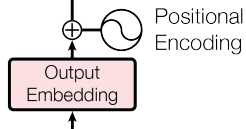

### Token Embedding

Each token is assigned a usually high-dimensional embedding vector. For this a **lookup-embedding** is used, which means that the corresponding embedding vector is fetched from a embedding matrix $ E_T \in \mathbb{R}^{(vocab size, C)} $, where $ C $ represents the number dimensions of the embedding vectors. This matrix contains learnable parameters.

In [33]:
C = 6  # 6 embedding dimensions

E_T = cp.random.uniform(shape=(vocab_size, C), low=-1, high=1)
E_T

Tensor([[ 0.0976,  0.4304,  0.2055,  0.0898, -0.1527,  0.2918],
        [-0.1248,  0.7835,  0.9273, -0.2331,  0.5835,  0.0578],
        [ 0.1361,  0.8512, -0.8579, -0.8257, -0.9596,  0.6652],
        [ 0.5563,  0.7400,  0.9572,  0.5983, -0.0770,  0.5611],
        [-0.7635,  0.2798, -0.7133,  0.8893,  0.0437, -0.1707],
        [-0.4709,  0.5485, -0.0877,  0.1369, -0.9624,  0.2353],
        [ 0.2242,  0.2339,  0.8875,  0.3636, -0.2810, -0.1259],
        [ 0.3953, -0.8795,  0.3335,  0.3413, -0.5792, -0.7421],
        [-0.3691, -0.2726,  0.1404, -0.1228,  0.9767, -0.7959],
        [-0.5822, -0.6774,  0.3062, -0.4934, -0.0674, -0.5111],
        [-0.6821, -0.7792,  0.3127, -0.7236, -0.6068, -0.2625],
        [ 0.6420, -0.8058,  0.6759, -0.8078,  0.9529, -0.0627],
        [ 0.9535,  0.2097,  0.4785, -0.9216, -0.4344, -0.7596],
        [-0.4077, -0.7625, -0.3640, -0.1715, -0.8717,  0.3849],
        [ 0.1332, -0.4692,  0.0465, -0.8121,  0.1519,  0.8586],
        [-0.3629,  0.3348, -0.7364,  0.4

The lookup embedding is performed by fetching the correspoding rows of the embedding matrix (the token IDs are used as indices), resulting in a tensor $ X_{E_T} \in \mathbb{R}^{(B, T, C)} $.

In [34]:
X_E_T = E_T[X]

print(X)
print(X_E_T)
print(X_E_T.shape)

Tensor([[ 7,  4, 11, 11, 14]])
Tensor([[[ 0.3953, -0.8795,  0.3335,  0.3413, -0.5792, -0.7421],
         [-0.7635,  0.2798, -0.7133,  0.8893,  0.0437, -0.1707],
         [ 0.6420, -0.8058,  0.6759, -0.8078,  0.9529, -0.0627],
         [ 0.6420, -0.8058,  0.6759, -0.8078,  0.9529, -0.0627],
         [ 0.1332, -0.4692,  0.0465, -0.8121,  0.1519,  0.8586]]])
(1, 5, 6)


### Positional Embedding

In the original implementation, the authors used a fixed positional encoding, giving each position a unique vector.

Tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.4477,  0.8942,  0.2138,  0.9769],
        [ 0.9093, -0.4161,  0.8006,  0.5992,  0.4177,  0.9086],
        [ 0.1411, -0.9900,  0.9841,  0.1774,  0.6023,  0.7983],
        [-0.7568, -0.6536,  0.9594, -0.2820,  0.7590,  0.6511]])


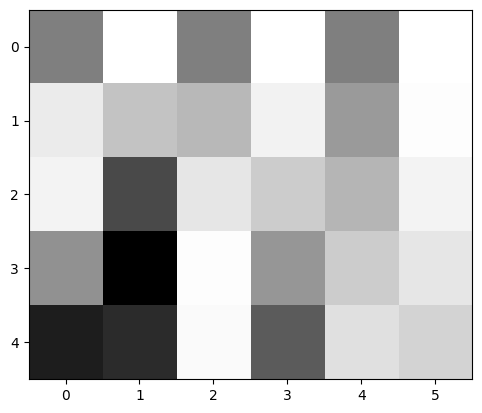

In [35]:
import matplotlib.pyplot as plt

BASE = 10  # different bases can be used depending on the embedding dimension. In the paper the authors used 10000 and an embedding dim of 512 - 1024

encodings = cp.zeros((T, C))
positions = cp.arange(T).view((T, 1))
emb_range = cp.arange(C, step=2)
div_term = cp.exp(emb_range * (-(math.log(10) / C)))
encodings[:, 0::2] = cp.sin(positions * div_term)
encodings[:, 1::2] = cp.cos(positions * div_term)

print(encodings)
plt.imshow(encodings, cmap="grey");

Alternatively, a learned positional embedding can be used. Since the position of the tokens instead of the token ids now have to be encoded, a seperate position embedding matrix $ E_P \in \mathbb{R}^{(T, C)} $ is used.  To be able to add both embeddings, the same embedding dimension $ C $ is used. This matrix also contains learnable parameters.

In [36]:
E_P = cp.random.uniform(shape=(T, C))
E_P

Tensor([[ 0.4441,  0.7328,  0.9510,  0.7116, -0.9766, -0.2800],
        [ 0.4600, -0.6567,  0.0421, -0.8913, -0.6000, -0.9630],
        [ 0.5874, -0.5522, -0.3093,  0.8562,  0.4088, -0.9363],
        [-0.6706,  0.2430,  0.1545, -0.5242,  0.8684,  0.2279],
        [ 0.0713,  0.1798,  0.4602, -0.3761, -0.2036, -0.5803]])

### Adding the embeddings

Altough, the two tensors have different dimensions, it works out because the position embeddings is broadcasted (replicated) along the batch dimension. After the broadcasting, the embeddings can be added element-wise.

- $ X_{E_T} \in \mathbb{R}^{B, T, C} $
- $ E_P \in \mathbb{R}^{(T, C)} $

To allow for element-wise addition a "fake" batch dimension is created through broadcasting (duplicating to make dimensions match). `Compute`-Tensors do this automatically. $$ E_P \in \mathbb{R}^{(T, C)} \longrightarrow E^{'}_{P} \in \mathbb{R}^{(B, T, C)} $$

In [37]:
X_E = X_E_T + E_P
X_E.shape

(1, 5, 6)

## Masked Multi-Head Attention

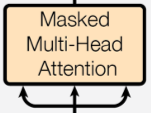

In an attention head, the scaled-dot-product-attention is performed.

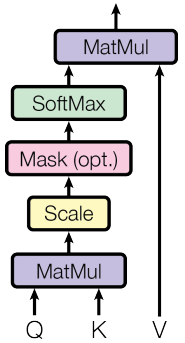

### Query, Key and Value

In the first step, every token-embedding-vector is projected into three new $ H $-dimensional spaces ($ H $ is called the "head size").
- Query $ Q $: contains information about what the token "is looking for" in other tokens.
- Key $ K $: contains information about what "the token can provide" to other tokens.
- Value $ V $: contains contextual information about the token

To create $ Q $, $ K $ and $ V $, projection matrices $ W_Q \in \mathbb{R}^{(C, H)} $, $ W_K \in \mathbb{R}^{(C, H)} $ and $ W_V \in \mathbb{R}^{(C, H)} $ are used containing learnable parameters.

In [38]:
H = 8  # head size, in multi-head-attention usually C // n_heads

W_Q = cp.random.uniform(shape=(C, H))
W_K = cp.random.uniform(shape=(C, H))
W_V = cp.random.uniform(shape=(C, H))

The embedding is linearly transformed using the weight matrices by performing a batched matrix multiplication (again, `Compyute` handles the missing batch dimension in the weight matrices by broadcasting (duplicating) the values B times.)
$$ Q = X_E W_Q, Q \in \mathbb{R}^{(B, T, H)} $$
$$ K = X_E W_K, K \in \mathbb{R}^{(B, T, H)} $$
$$ V = X_E W_V, V \in \mathbb{R}^{(B, T, H)} $$

In [39]:
# (B, T, H) = (B, T, C) @ ((B), C, H)
Q = X_E @ W_Q
K = X_E @ W_K
V = X_E @ W_V

print(f"{Q.shape=}")
print(f"{K.shape=}")
print(f"{V.shape=}")

Q.shape=(1, 5, 8)
K.shape=(1, 5, 8)
V.shape=(1, 5, 8)


### The Attention Mechanism

$$ Attn(Q, K, V) = softmax \left( \frac{Q K^T}{\sqrt{H}} \right) V $$

The first step in the attention mechanism is the dot-product between $ Q $ and $ K^T $. This is where tokens "communicate" by computing a similarity score between a tokens' query (rows) and the keys (columns) of all other tokens that come before it (causal attention). A high similarity score can be interpreted as how important other tokens are to a specific token.

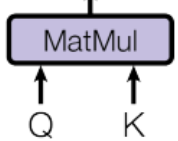

In [40]:
# (B, T, T) = (B, T, H) @ (B, H, T)
dot_product = Q @ K.T

print(f"{dot_product.shape=}")
dot_product

dot_product.shape=(1, 5, 5)


Tensor([[[ 5.1272, -1.3822,  4.3237,  6.5092,  1.7702],
         [-3.7746,  0.9463, -1.6497, -3.4746, -4.2239],
         [-8.8323, -2.3207,  1.9599, 13.1900,  5.1792],
         [-3.3587, -3.5372,  0.9251,  7.3541,  6.4410],
         [ 4.0946, -1.4543,  0.3540, -0.2205,  2.4579]]])

According to Vaswani et. al, computing the dot product results in **extremely small gradients**. The dot-product can result in high absolute values, which, when fed into the softmax function later on, causes the **weight distribution to be close to a one-hot vector**. Other tokens therefore do not learn a lot, because their contribution in the forward pass is low and therefore their gradients in the backward pass vanish. The authors therefore propose a scaling by dividing the dot-product by the square root of the head size (element-wise) to counteract the increasing variance.

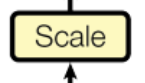

In [41]:
scaled_dot_product = dot_product / math.sqrt(H)
scaled_dot_product

Tensor([[[ 1.8127, -0.4887,  1.5287,  2.3013,  0.6259],
         [-1.3345,  0.3346, -0.5833, -1.2284, -1.4934],
         [-3.1227, -0.8205,  0.6929,  4.6634,  1.8311],
         [-1.1875, -1.2506,  0.3271,  2.6001,  2.2772],
         [ 1.4476, -0.5142,  0.1251, -0.0780,  0.8690]]])

There are different types of attention, for example
- *self-attention*: $ Q $, $ K $ and $ V $ are computed from the same input.
- *causal self-attention*: $ Q $, $ K $ and $ V $ are computed from the same input, but **queries are not allowed to communicate with "future keys" (subsequent tokens in the time dimension)**.
- *cross-attention*: used in encoder-decoder transformers, $ Q $, $ K $ come from a encoder block.

In this project, causal self-attention will be implemented. Therefore, keys "from the future" must be masked out and are not allowed to contribute. This is achieved by replacing the values with `-inf` as this will be set to 0 by the softmax function later on.

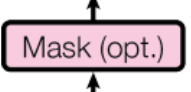

In [42]:
# triu returns the upper triangle of the -inf matirx.
mask = cp.triu(cp.full_like(scaled_dot_product, value=float("-inf")), diag_index=1)
mask

Tensor([[[  0., -inf, -inf, -inf, -inf],
         [  0.,   0., -inf, -inf, -inf],
         [  0.,   0.,   0., -inf, -inf],
         [  0.,   0.,   0.,   0., -inf],
         [  0.,   0.,   0.,   0.,   0.]]])

In [43]:
masked_dp = scaled_dot_product + mask
masked_dp

Tensor([[[ 1.8127,    -inf,    -inf,    -inf,    -inf],
         [-1.3345,  0.3346,    -inf,    -inf,    -inf],
         [-3.1227, -0.8205,  0.6929,    -inf,    -inf],
         [-1.1875, -1.2506,  0.3271,  2.6001,    -inf],
         [ 1.4476, -0.5142,  0.1251, -0.0780,  0.8690]]])

After masking, the softmax is applied. Usually softmax is used to transform vector elements into a probability distribution, but here it is used to create attention weights, that determine how much information each token aggregates from other tokens.

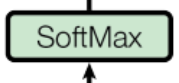

$$ softmax(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{T}{e^{x_j}}} $$

In [44]:
exp_ = cp.exp(masked_dp)
sm = exp_ / cp.sum(exp_, dim=-1, keepdims=True)
sm

Tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1585, 0.8415, 0.0000, 0.0000, 0.0000],
         [0.0177, 0.1772, 0.8050, 0.0000, 0.0000],
         [0.0197, 0.0185, 0.0898, 0.8719, 0.0000],
         [0.4576, 0.0643, 0.1219, 0.0995, 0.2566]]])

To compute the final attention score, the softmax scores and $ V $ are multiplied.

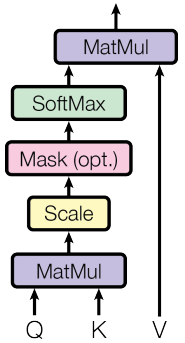

In [45]:
# (B, T, H) = (B, T, T) @ (B, T, H)
A = sm @ V
A

Tensor([[[ 0.1472, -0.0322,  1.0940, -2.4009,  2.4798, -2.0018,  0.3823,
          -1.9446],
         [ 1.0140,  0.5719,  1.3797, -0.3470,  0.7844, -0.1159, -0.8495,
          -0.2162],
         [ 0.8425, -1.1997, -1.6862, -2.9443,  0.1933, -1.9031,  0.3437,
           0.1471],
         [ 0.5405, -1.1372, -3.0638, -1.4075, -0.7220, -1.4249,  0.4264,
           0.0693],
         [ 0.5564, -0.1509, -0.3525, -1.6760,  1.1086, -1.5303,  0.1402,
          -1.0108]]])

This completes the attention mechanism.

$$ A \in \mathbb{R}^{(B, T, H)} $$ 

## Addition and Normalization

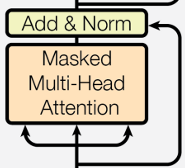

### Addition

The addition here refers to the skip-connection that is used in the transformer architecture. These were introduced by He et. al (https://arxiv.org/abs/1512.03385). To be able to add the embeddings to the attention output a projection is needed, since the tensors have different dimensions.

$$ A_{proj} = A W_{proj}, W_{proj} \in \mathbb{R}^{(H, C)}$$


In [46]:
W_proj = cp.random.uniform((H, C))

# (B, T, C) = (B, T, C) + (B, T, H) @ ((B), H, C)
add = X_E + A @ W_proj
add

Tensor([[[-1.3230,  2.1377, -0.3129,  0.7110, -1.6672, -2.7277],
         [-1.6093,  0.3749,  0.6675, -1.4876, -1.0601, -3.0959],
         [-0.3642, -2.4346, -0.9808,  3.4472,  1.6902, -2.7897],
         [-0.7482, -3.1564, -1.4096,  2.5017,  1.5623, -0.1163],
         [-1.4502, -0.1653, -0.7790, -0.4276, -0.3866, -1.1263]]])

### Normalization

This refers to layer normalization (https://arxiv.org/pdf/1607.06450). To address the vanishing/exploding gradient problem, values are normalized using mean $ \mu $ and standard deviation $ \sigma $ which are computed over **all dimension except the batch dimension**. To allow for learning, a shifting $ b $ and scaling $ \gamma $ is introduced.

$$ Y = \gamma \cdot (\frac{X - \mu}{\sigma}) + b $$

In [47]:
# gamma and b are initialized such that there is no scaling and shifting in the beginning
# These are learnable parameters
gamma = cp.ones(shape=(T, C))
b = cp.zeros(shape=(T, C))

mu = cp.mean(add, dim=(1, 2), keepdims=True)
sigma = cp.std(add, dim=(1, 2), keepdims=True)

# (B, T, C) = ((B), T, C) * ((B, T, C) - (B, (T), (C))) / (B, (T), (C)) + ((B), T, C)
norm = gamma * ((add - mu) / sigma) + b
norm

Tensor([[[-0.4751,  1.6542,  0.1464,  0.7764, -0.6869, -1.3394],
         [-0.6513,  0.5696,  0.7496, -0.5764, -0.3133, -1.5659],
         [ 0.1148, -1.1591, -0.2645,  2.4600,  1.3789, -1.3776],
         [-0.1215, -1.6032, -0.5284,  1.8783,  1.3002,  0.2674],
         [-0.5534,  0.2372, -0.1404,  0.0758,  0.1011, -0.3541]]])

In [48]:
print(f"mean={cp.mean(norm, dim=(1, 2))}")
print(f"std={cp.std(norm, dim=(1, 2))}")

mean=Tensor([-1.9868e-08])
std=Tensor([1.])


This concludes the main Transformer-components. Stacked on top of the Transformer-Block is a simple Feed-Forward-Network.